In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import tensorflow as tf

from IPython.display import display
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import model_from_json
# Train your model...

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
train_dir = 'data/train'
test_dir = 'data/test'
img_width, img_height = 224, 224


In [5]:
# Define data generators with augmentations for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Data generator for test data (without augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:


batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7500 images belonging to 3 classes.
Found 2850 images belonging to 3 classes.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


num_train_samples = train_generator.samples
num_test_samples = test_generator.samples




# Calculate steps per epoch and validation steps
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_test_samples // batch_size

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)


C:\Users\KAMAL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/20
234/234 [==============================] - 190s 748ms/step - loss: 0.1497 - accuracy: 0.9412 - val_loss: 0.0588 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 2/20
234/234 [==============================] - 147s 626ms/step - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.2487 - val_accuracy: 0.9414 - lr: 1.0000e-04
Epoch 3/20
234/234 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9952
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
234/234 [==============================] - 153s 654ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.4997 - val_accuracy: 0.9094 - lr: 1.0000e-04
Epoch 4/20
234/234 [==============================] - 161s 685ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.1159 - val_accuracy: 0.9663 - lr: 2.0000e-05
Epoch 4: early stopping


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


num_train_samples = train_generator.samples
num_test_samples = test_generator.samples




# Calculate steps per epoch and validation steps
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_test_samples // batch_size

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)


In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.save('model.h5')

1/1 [==============================] - 0s 182ms/step


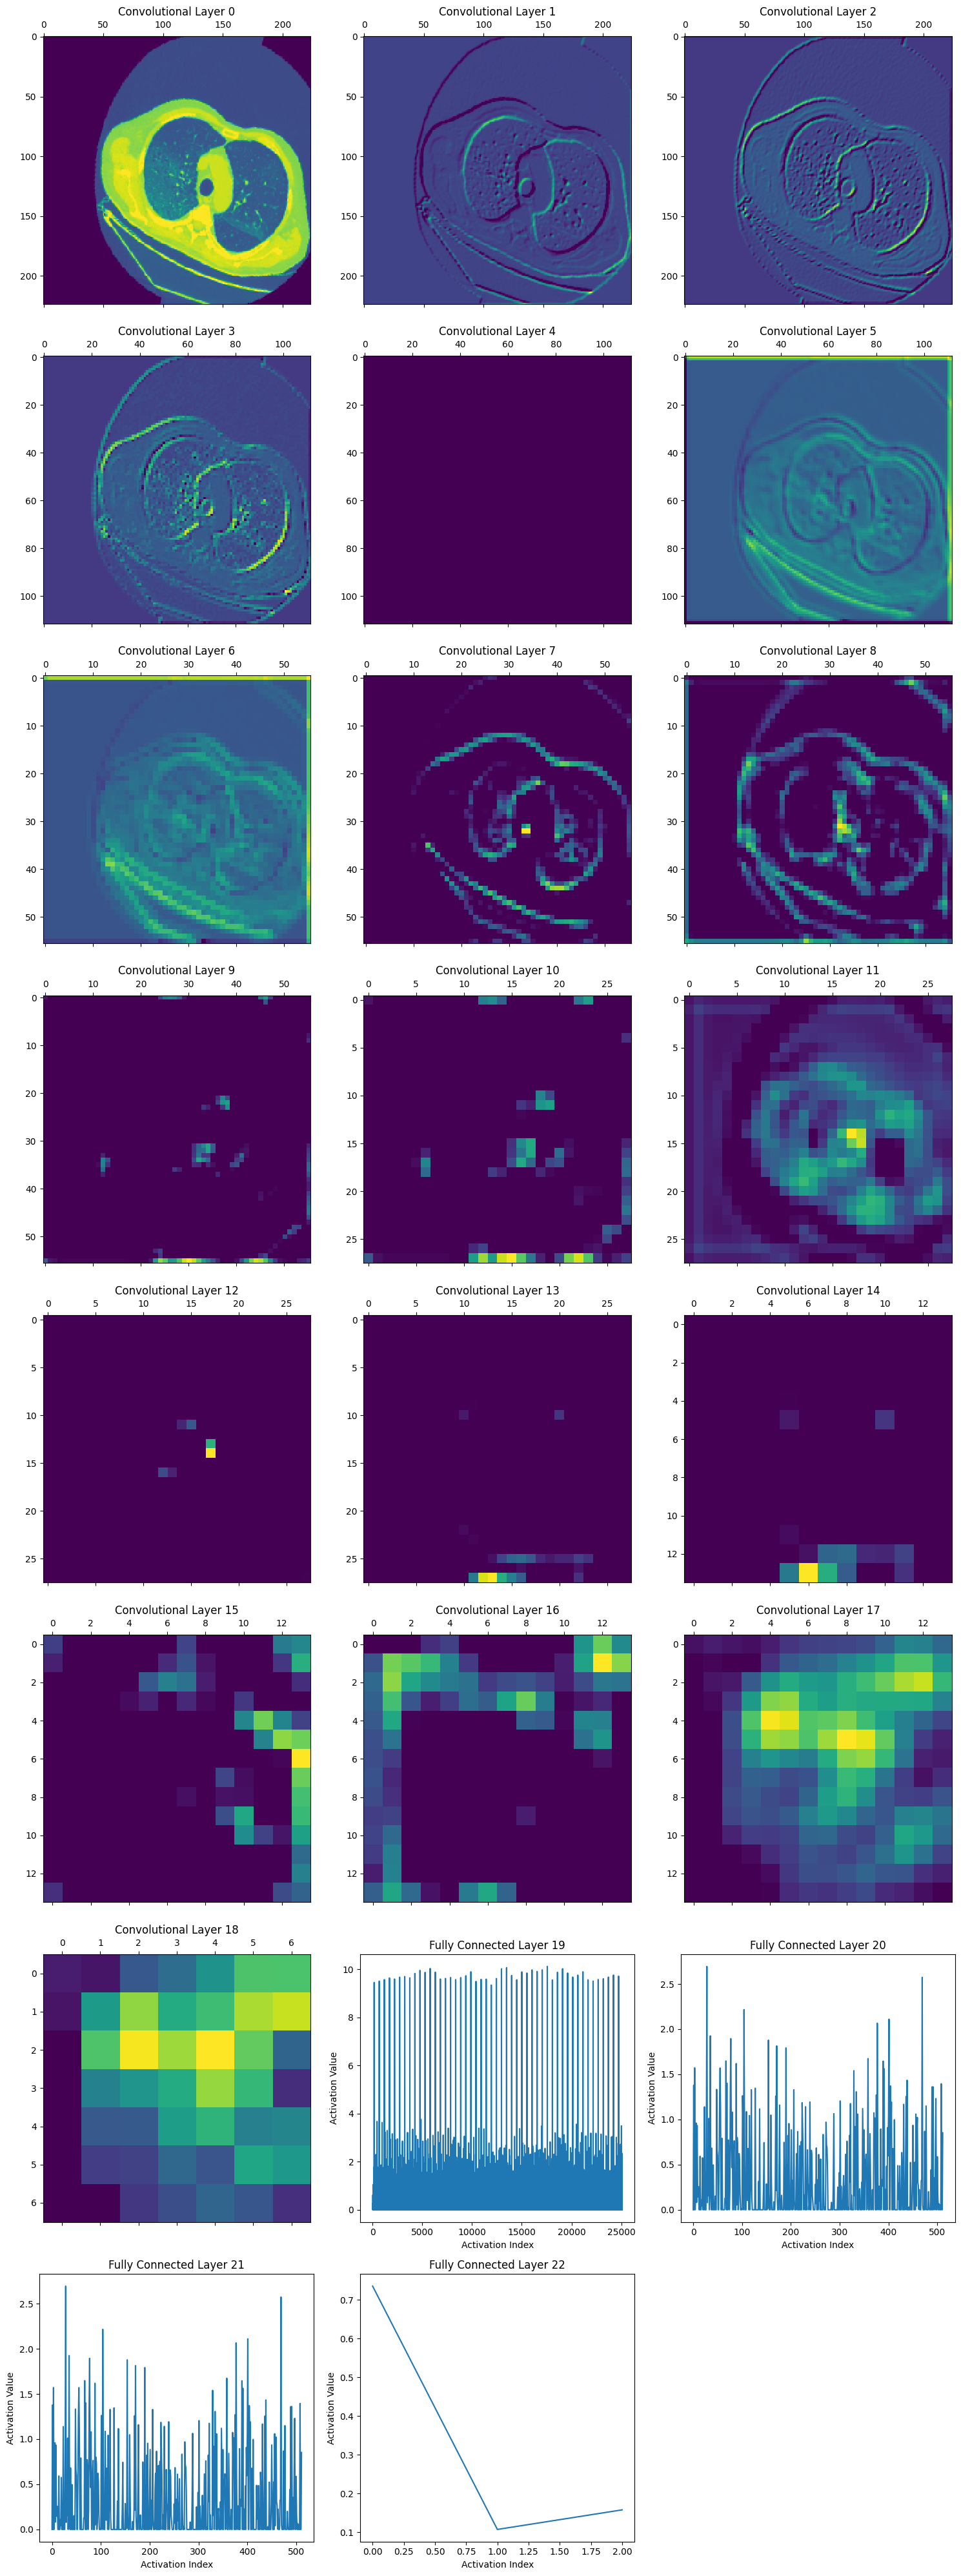

In [33]:
activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
# Load a batch of images and labels from the generator
images, labels = next(train_generator)

# Select the first image from the batch
img = images[0]

# Reshape the image to match the input shape of the model
img = np.expand_dims(img, axis=0)

# Get the activations of all layers for the input image
activations = activation_model.predict(img)

# Get layer names
layer_names = [layer.name for layer in model.layers]

# Calculate the number of rows and columns for subplots
num_layers = len(activations)
num_cols = 3  # Set to 3 columns
num_rows = (num_layers + num_cols - 1) // num_cols

# Define the size of each subplot
subplot_size = 5  # Adjust as needed

# Calculate the total size of the figure
fig_width = subplot_size * num_cols
fig_height = subplot_size * num_rows

# Visualize the output of each layer
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

for i, activation in enumerate(activations):
    if len(activation.shape) == 2:  # For fully connected layers
        # Reshape the activation to 1D
        activation_reshaped = activation.reshape((-1,))
        # Plot the activation values directly
        ax = axes[i // num_cols, i % num_cols]
        ax.plot(activation_reshaped)
        ax.set_title('Fully Connected Layer {}'.format(i))
        ax.set_xlabel('Activation Index')
        ax.set_ylabel('Activation Value')
    elif len(activation.shape) == 4:  # For convolutional layers
        ax = axes[i // num_cols, i % num_cols]
        ax.matshow(activation[0, :, :, 0], cmap='viridis')
        ax.set_title('Convolutional Layer {}'.format(i))
    else:
        print("Unsupported activation shape for layer", layer_names[i])

# Hide any unused subplots
for i in range(num_layers, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()
plt.show()


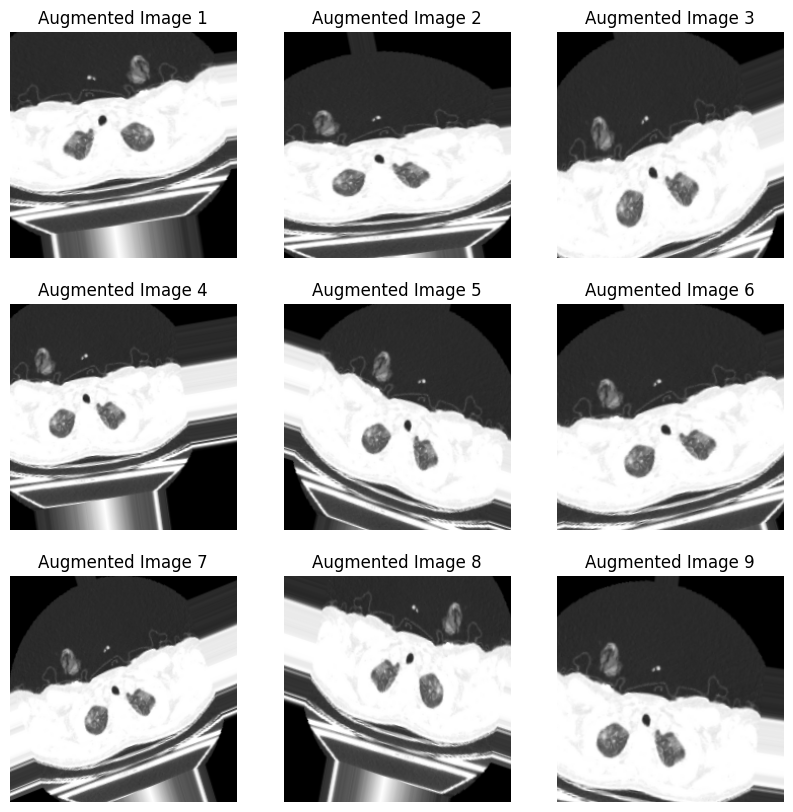

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Select a single image from the batch
img = images[0]

# Expand dimensions to make it a 4D tensor (batch size of 1)
img = np.expand_dims(img, axis=0)

# Generate augmented images using the data generator
augmented_images = [train_datagen.random_transform(img[0]) for _ in range(num_augmented_images)]

# Plot the original image and the augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])
    ax.axis('off')
    ax.set_title(f'Augmented Image {i+1}')

plt.show()


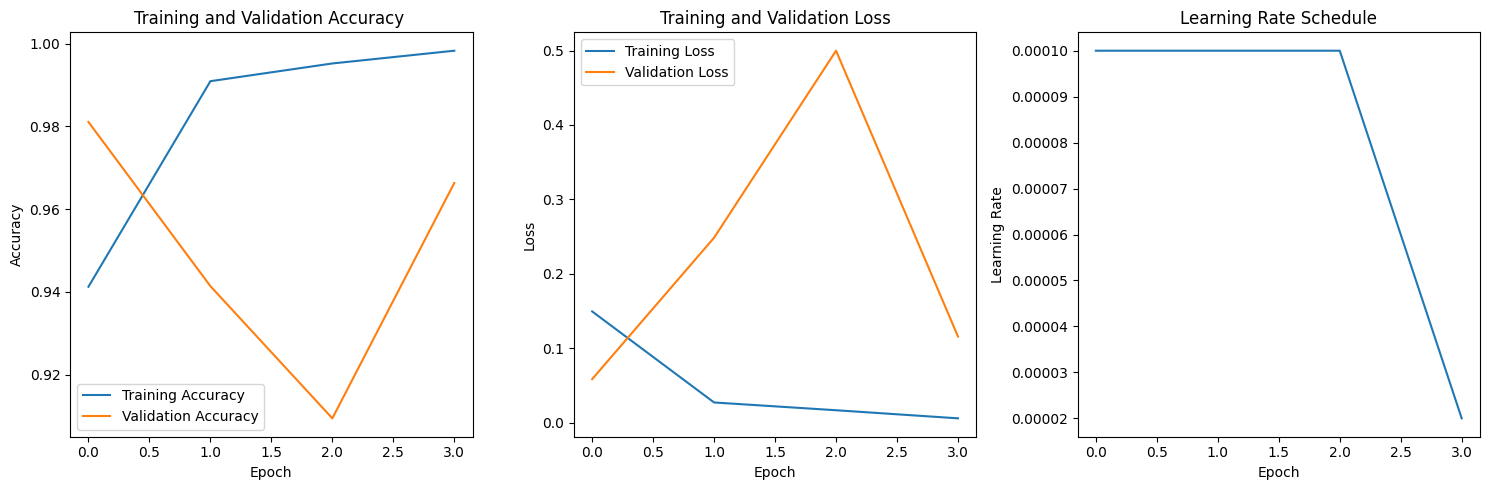

In [18]:
# Plotting accuracy, loss, and learning rate in the same row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy ')
axs[0].legend()

# Loss plot
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Learning rate plot
axs[2].plot(history.history['lr'])
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test accuracy:', test_accuracy)

In [ ]:


# After training, serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_weights.h5")


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)


90/90 [==============================] - 26s 284ms/step


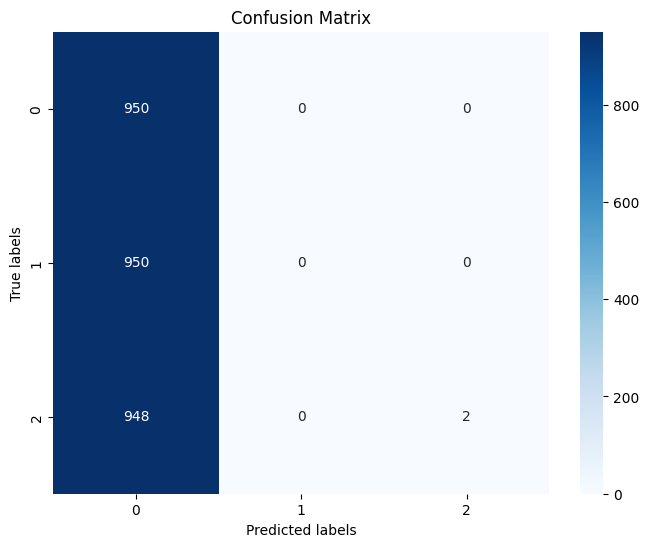

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
from sklearn.metrics import classification_report

# Generate classification report
class_names = ['Class 0', 'Class 1', 'Class 2']  # Update class names accordingly
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))


              precision    recall  f1-score   support

     Class 0       0.33      1.00      0.50       950
     Class 1       0.00      0.00      0.00       950
     Class 2       1.00      0.00      0.00       950

    accuracy                           0.33      2850
   macro avg       0.44      0.33      0.17      2850
weighted avg       0.44      0.33      0.17      2850



C:\Users\KAMAL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KAMAL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KAMAL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

553467096/553467096 [==============================] - 143s 0us/step
Found 2850 images belonging to 3 classes.
90/90 [==============================] - 25s 275ms/step


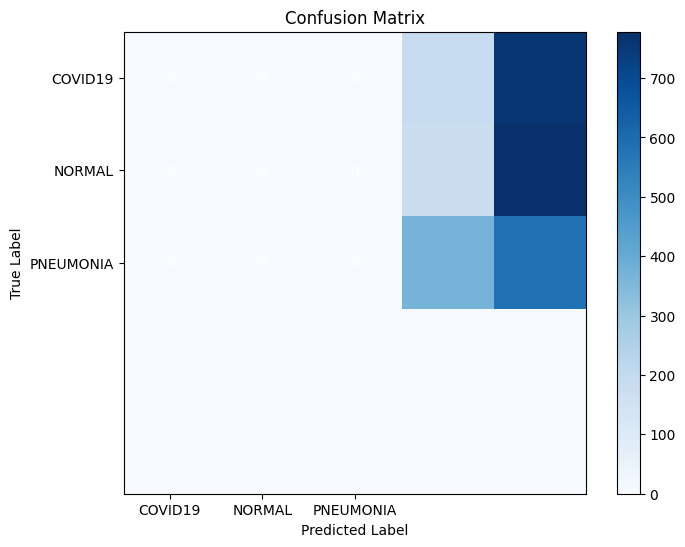

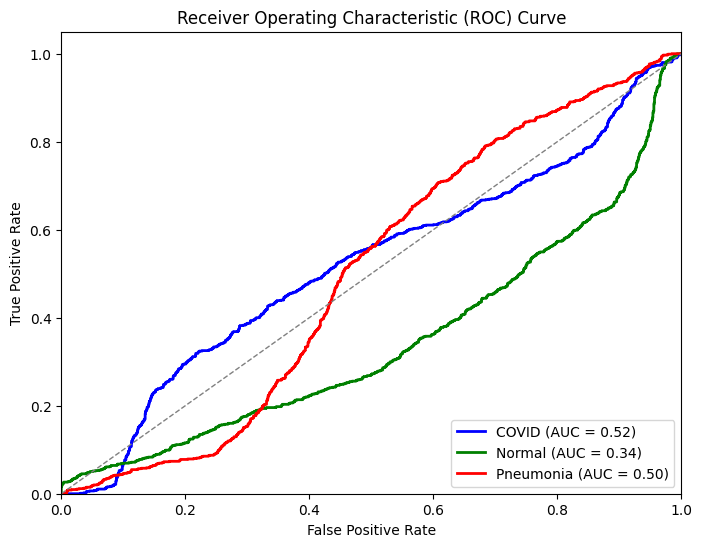

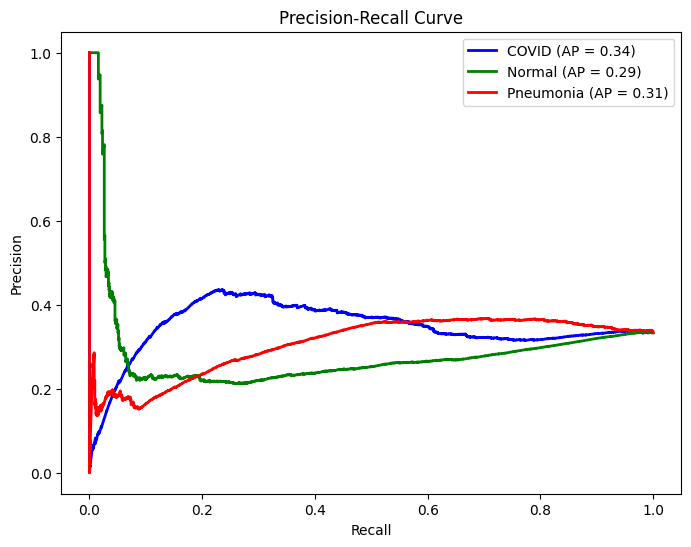

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras import backend as K

# Load VGG16 model
vgg_model = VGG16(weights='imagenet')

# Function to preprocess an image
def preprocess_image(img):
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    return x

# Function to generate class activation map (CAM) for a given image and target class
def generate_cam(img, model, target_class):
    last_conv_layer = model.get_layer('block5_conv3')
    model = Model(inputs=model.input, outputs=last_conv_layer.output)
    img = preprocess_image(img)
    with tf.GradientTape() as tape:
        last_conv_output = model(img)
        tape.watch(last_conv_output)
        preds = model(img)
        output = preds[:, target_class]
    grads = tape.gradient(output, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_output), axis=-1)
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)
    return cam

# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_probs = vgg_model.predict(test_generator)

# Get predicted labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(3), labels=test_generator.class_indices.keys())
plt.yticks(ticks=np.arange(3), labels=test_generator.class_indices.keys())
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white')
plt.show()

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label='COVID (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='Normal (AUC = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='red', lw=2, label='Pneumonia (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

plt.figure(figsize=(8, 6))
plt.plot(recall[0], precision[0], color='blue', lw=2, label='COVID (AP = %0.2f)' % average_precision[0])
plt.plot(recall[1], precision[1], color='green', lw=2, label='Normal (AP = %0.2f)' % average_precision[1])
plt.plot(recall[2], precision[2], color='red', lw=2, label='Pneumonia (AP = %0.2f)' % average_precision[2])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
